In [1]:
!pip install torchsummary

In [2]:
!pip install mealpy==2.5.1

In [3]:
import os
import torch
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import torchvision.datasets as dt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import tqdm
import torchsummary as summary
from sklearn.svm import SVC
from sklearn import metrics
if torch.cuda.is_available():
    device = 'cuda'
    print('GPU initialized')
else:
    device = 'cpu'
    print('GPU not found')


GPU initialized


In [4]:
def imshow(img):
    image = img.numpy().transpose((1,2,0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.pause(.001)

In [5]:
def invNormalize(img):
    image = img.numpy().transpose((1,2,0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

In [6]:
path = '/notebooks/Banana'
batchSize = 64
valSplit = .2
testSplit = .1
trainSplit = 1 - (valSplit+testSplit)
dataset = dt.ImageFolder(root=path)
datasetSize = len(dataset)
splitSize = {
    'train' : int((trainSplit*datasetSize)+1),
    'val' : int((valSplit*datasetSize)),
    'test' : int((testSplit*datasetSize))
}
trainDataset, valDataset, testDataset = random_split(dataset, [splitSize['train'], splitSize['val'], splitSize['test']])

trainDataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(.2),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225])
])

valDataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225])
])

testDataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225])
])

loader = {
    'train' : DataLoader(trainDataset),
    'val' : DataLoader(valDataset),
    'test' : DataLoader(testDataset)
}

size = {
    'train' : len(trainDataset),
    'val' : len(valDataset),
    'test' : len(testDataset)
}

classNames = dataset.classes

print(classNames)
print(len(classNames))
print(size['train'])
print(size['val'])
print(size['test'])

['Banana G1', 'Banana G2', 'Banana Rotten']
3
1172
334
167


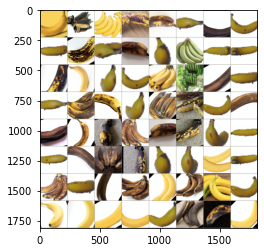

In [12]:
trainIter = iter(loader['train'])
images, labels = trainIter.next()
imshow(torchvision.utils.make_grid(images))

In [7]:
modelTuning = torchvision.models.resnext50_32x4d(pretrained=False)
modelTuning.to(device)
summary.summary(modelTuning, input_size=(3, 224,224))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
newClassifier = nn.Sequential(*list(modelTuning.children())[:-1])
modelTuning = newClassifier

In [9]:
summary.summary(modelTuning, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
def getFeature(model, loader):
    model.eval()
    with torch.no_grad():
        features = None
        imageLabels = None
        # realImage = None
        for image, label in tqdm.tqdm(loader):
            img = image
            inputs = image.to(device)
            output = model(inputs)
            
            if features is not None:
                features = torch.cat((features, output), 0)
                imageLabels = torch.cat((imageLabels, label), 0)
                realImage = torch.cat((realImage, img), 0)
            else:
                features = output
                imageLabels = label
                realImage = img
        features = features.view(features.size(0), -1)       
        features = features.cpu().numpy()
        imageLabels = imageLabels.cpu().numpy()
    return (features, imageLabels, realImage)

In [11]:
def showPredicted(data, label, image, kernel=None, C=None):
    plt.figure(figsize=(10,10))
    
    if C and kernel:
        model = SVC(C = C, kernel = kernel)
    else:
        model = SVC()
    start = time.time()
    model.fit(trainImage, trainLabel)
    exc = time.time() - start
    print(f"training time is {exc//60:.0f} minutes and {exc%60:.0f} seconds")
    valAcc = model.score(valImage, valLabel)
    print(f"Validation accuracy is {valAcc:.4f}")
    preds = model.predict(data)
    
    
    for k in range(6):
      ax = plt.subplot(3,3,k+1)
      plt.title(f'Predicted Class : {classNames[preds[k]]}\nReal Class : {classNames[label[k]]}')
      plt.axis('off')
      plt.imshow(invNormalize(image[k]))

    # predsList = np.concatenate([x for x in predsList], axis=0)
    # predsList = np.array(predsList).squeeze()
    # print(predsList)
    print(metrics.classification_report(label, preds, target_names=classNames))
    # print(pred)
    # print(truth)
    plt.figure(figsize=(10,10))
    cfMatrix = metrics.confusion_matrix(label, preds)
    df = pd.DataFrame(cfMatrix, index=[i for i in classNames], columns=[i for i in classNames])
    sn.heatmap(df, annot=True)

In [12]:
trainImage, trainLabel, trainRImage = getFeature(modelTuning, loader['train'])
valImage, valLabel, valRImage = getFeature(modelTuning, loader['val'])
testImage, testLabel, testRImage = getFeature(modelTuning, loader['test'])

100%|██████████| 167/167 [00:05<00:00, 31.23it/s]


training time is 0 minutes and 2 seconds
Validation accuracy is 0.8024


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

    Banana G1       0.77      1.00      0.87       102
    Banana G2       0.00      0.00      0.00        11
Banana Rotten       0.83      0.54      0.65        54

     accuracy                           0.78       167
    macro avg       0.53      0.51      0.51       167
 weighted avg       0.74      0.78      0.74       167



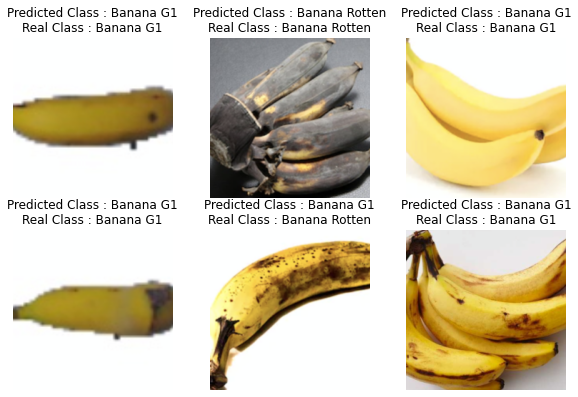

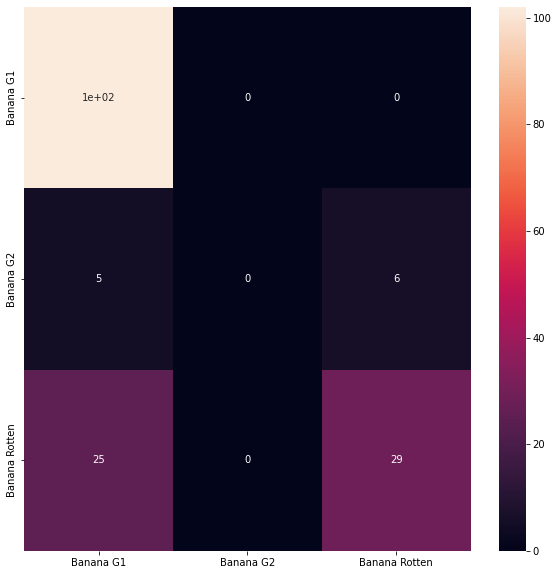

In [13]:
showPredicted(testImage, testLabel, testRImage)

In [14]:
from mealpy.swarm_based.ABC import OriginalABC
from sklearn.preprocessing import LabelEncoder
# from sklearn import metrics

kernelEncoder = LabelEncoder()
kernelEncoder.fit(['linear', 'poly', 'rbf', 'sigmoid'])

def fitnessFunction(solution):
    kernelEncoded = int(solution[0])
    c = solution[1]
    kernelDecoded = kernelEncoder.inverse_transform([kernelEncoded])[0]
    
    svc = SVC(C = c, random_state=1, kernel=kernelDecoded)
    svc.fit(trainImage, trainLabel)
    preds = svc.predict(testImage)
    return metrics.accuracy_score(testLabel, preds)

problem = {
    "fit_func" : fitnessFunction,
    "lb" : [0, 0.1],
    "ub" : [3.99, 1000],
    "minmax" : "max"
}

EPOCH = 10

model = OriginalABC(epoch=EPOCH)
model.solve(problem)
print(f"Solution : {model.solution[0]}")
print(f"Best Kernel : {kernelEncoder.inverse_transform([int(model.solution[0][0])])}, Best C: {model.solution[0][1]}")
print(f"Best accuracy : {model.solution[1]}")

bestKernel = kernelEncoder.inverse_transform([int(model.solution[0][0])])
bestC = model.solution[0][1]

2022/12/22 12:37:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving single objective optimization problem.
2022/12/22 12:39:53 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: P, Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 65.68447 seconds
2022/12/22 12:40:59 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: P, Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 66.72472 seconds
2022/12/22 12:42:08 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: P, Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 68.70994 seconds
2022/12/22 12:43:14 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: P, Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 66.40903 seconds
2022/12/22 12:44:24 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: P, Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 69.28329 seconds
2022/12/22 12:45:35 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: P, Epoch: 6, Current best: 1.0, Global best: 1.0, R

Solution : [  1.99293958 604.95443777]
Best Kernel : ['poly'], Best C: 604.9544377662495
Best accuracy : [1.0, [1.0]]


training time is 0 minutes and 0 seconds
Validation accuracy is 0.9880
               precision    recall  f1-score   support

    Banana G1       1.00      1.00      1.00       102
    Banana G2       1.00      1.00      1.00        11
Banana Rotten       1.00      1.00      1.00        54

     accuracy                           1.00       167
    macro avg       1.00      1.00      1.00       167
 weighted avg       1.00      1.00      1.00       167



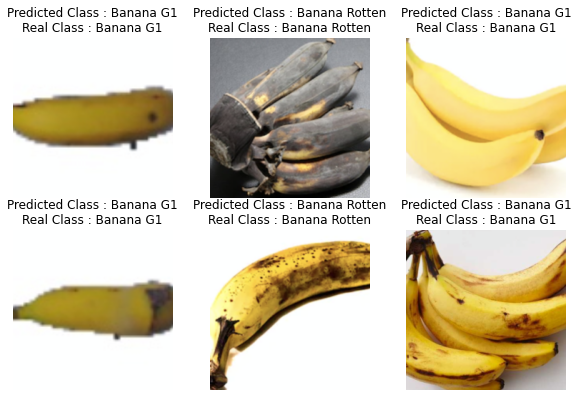

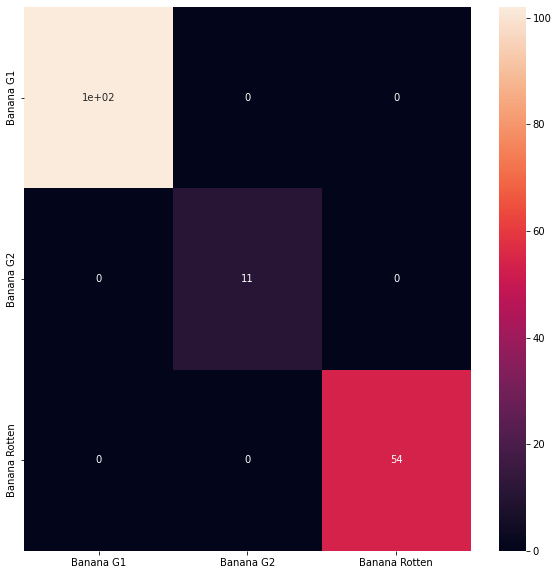

In [15]:
showPredicted(testImage, testLabel, testRImage, bestKernel, bestC)